In [1]:
using Turing, Distributions, Gadfly, DataFrames

    +(AbstractArray, DataArrays.DataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


In [2]:
include("very-big-hmm.jl")


Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.


big_hmm (generic function with 1 method)

> Note on experiment:
- Experiments are done with SMC because the replaying version of PG is probalmatic in Truing.
- Experiments are done with 150 particles, simply because I can't run more in Probablistic C.
- Use replaying version by changing `TraceC` to `TraceR` in `smc.jl`

Define a helper function to collection counts from `Profile`.

In [3]:
function gen_counts()
    f = open("/Users/kai/temp/prof.txt","w")
    Profile.print(f, format=:flat)
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt","w")
    Profile.print(f, maxdepth=0)
    close(f)
    
    fork_count = 0
    total_count = 0

    f = open("/Users/kai/temp/prof.txt")
    for ln in eachline(f)
        if contains(ln, "fork") fork_count += parse(Int, ln[1:6]) end
    end
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt")
    for ln in eachline(f)
        if ln[2] != 'C' total_count += parse(Int, ln[1:3]) end
    end
    close(f)

    return fork_count, total_count
end
;

Profile steps
1. Change the copying method in the source code
2. Run the block below
3. Copy the counting output to the next block

In [4]:
forks = []
totals = []

for _ = 1:10
    Profile.init(delay=0.01)
    Profile.clear()
    @profile sample(big_hmm, SMC(25))
    fork_count, total_count = gen_counts()
    push!(forks, fork_count)
    push!(totals, total_count)
end

println(forks)
println(totals)
;

Any[7,11,11,11,10,16,7,14,8,10]
Any[376,144,164,208,167,173,170,141,139,137]


All pre-generated counts are loaded/defined below.

In [5]:
forks_process = []
for i = 1:10
    df = readtable("./exp1/probc/fork$i.csv", separator = ',', header = false)
    push!(forks_process, sum([df[1,i] for i = 1:(length(df[1,:])-1)]))
end
# totals_process = [17300,18811,18104,17864,18827,18051,18474,18355,18170,15699]
totals_process = []
df = readtable("./exp1/probc/total.txt", header = true)
for e in df[:,1]
    push!(totals_process, e)
end

forks_coroutine= [7,11,11,11,10,16,7,14,8,10]
totals_coroutine= [376,144,164,208,167,173,170,141,139,137]

forks_replaying= [65,44,53,46,38,52,32,61,45,51]
totals_replaying= [327,321,323,301,310,344,296,294,285,297]
;

Creating stats for plotting.

In [6]:
fracs_process = [Float64(forks_process[i] / totals_process[i]) for i = 1:1]
fracs_replaying = [Float64(forks_replaying[i] / totals_replaying[i]) for i = 1:10]
fracs_coroutine = [Float64(forks_coroutine[i] / totals_coroutine[i]) for i = 1:10]

means_process = mean(fracs_process)
means_replaying = mean(fracs_replaying)
means_coruntine = mean(fracs_coroutine)

stds_process = std(fracs_process)
stds_replaying = std(fracs_replaying)
stds_coruntine = std(fracs_coroutine)

mins_process = means_process - (1.96 * stds_process / sqrt(10))
mins_replaying = means_replaying - (1.96 * stds_replaying / sqrt(10))
mins_coruntine = means_coruntine - (1.96 * stds_coruntine / sqrt(10))

maxs_process = means_process + (1.96 * stds_process / sqrt(10))
maxs_replaying = means_replaying + (1.96 * stds_replaying / sqrt(10))
maxs_coruntine = means_coruntine + (1.96 * stds_coruntine / sqrt(10))
;

Make plot.

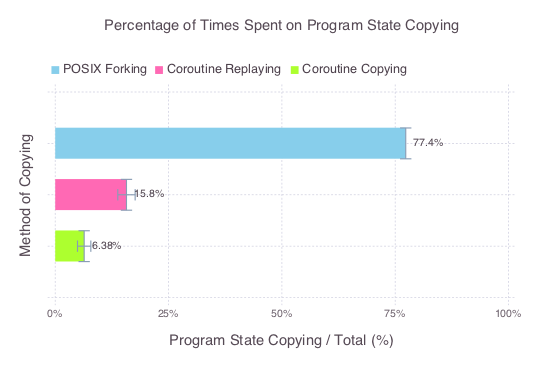

In [7]:
layer_errorbar = layer(
    ymax = [1, 2, 3] .+ 0.3, ymin = [1, 2, 3] .- 0.3,
    x = [means_coruntine, means_replaying, means_process],
    xmin = [mins_coruntine, mins_replaying, mins_process],
    xmax = [maxs_coruntine, maxs_replaying, maxs_process],
Geom.errorbar, Theme(default_color=colorant"lightsteelblue")
)

m_p = round(means_process + 0.001, 3) * 100
m_r = round(means_replaying + 0.001, 3) * 100 # 0.0001 is for correct presion showing in plot
m_c = round(means_coruntine, 4) * 100

layer_label = layer(
    y = [3, 2, 1],
    x = [means_process, means_replaying, means_coruntine],
label = ["$m_p%", "$m_r%", "$m_c%"], Geom.label(position=:right)
)

layer_process = layer(
    ymax = [3 + 0.3], ymin = [3 - 0.3], x = [means_process], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"skyblue")
)

layer_replaying = layer(
    ymax = [2 + 0.3], ymin = [2 - 0.3], x = [means_replaying], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"hotpink")
)

layer_coroutine = layer(
    ymax = [1 + 0.3], ymin = [1 - 0.3], x = [means_coruntine], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"greenyellow")
)

p = plot(
    layer_label,
    layer_errorbar,
    layer_coroutine, layer_replaying, layer_process,
    Stat.yticks(ticks=[0, 1, 2, 3, 4]),
    Stat.xticks(ticks=[0.00, 0.25, 0.50, 0.75, 1.00]),
Guide.title("Percentage of Times Spent on Program State Copying"),
Guide.manual_color_key(
"",["POSIX Forking   ","Coroutine Replaying   ", "Coroutine Copying"], 
["skyblue", "hotpink", "greenyellow"]),
Theme(key_position=:top, key_label_font_size=9.5pt),
    Guide.yticks(label=false),
Guide.ylabel("Method of Copying"), 
    Guide.xlabel("Program State Copying / Total (%)"),

    Coord.Cartesian(xmax=1.00),
Scale.x_continuous(labels=x->"$(round(Int, x*100))%")
)

Save plot to pdf.

In [8]:
draw(PDF("exp1.pdf", 5inch, 3.75inch), p)

> Environment:
- OS: macOS Sierra v10.12
- Machine: MacBook Pro (Retina, 13-inch, Late 2013)
- Processor: 2.4 GHz Intel Core i5
- Memory: 8 GB 16000 MHz DDR3
- Graphics:Intel Iris 1536 MB

> Note: number of cores used is limited to 1 for this experiment.